In [1]:
#!/usr/bin/env python
# coding: utf-8


import numpy as np
import pandas as pd

import _pickle as cPickle
import argparse
from copy import deepcopy
import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error
import time
from tqdm import tqdm

In [2]:
parser = argparse.ArgumentParser()
arg = parser.add_argument
arg('seed', type=int)
arg('iteration_mul', type=float)
arg('train_file', type=str)
arg('test_file', type=str)
arg('--learning_rate', type=float, default=0.05)
arg('--num_leaves', type=int, default=31)
arg('--colsample_bytree', type=float, default=0.8)
arg('--subsample_freq', type=int, default=1)
arg('--subsample', type=float, default=0.8)
arg('--n_estimators', type=int, default=500)
args = parser.parse_args(args=['1', '0.5','train_fe.ftr', 'test_fe.ftr'])

print(args)

Namespace(colsample_bytree=0.8, iteration_mul=0.5, learning_rate=0.05, n_estimators=500, num_leaves=31, seed=1, subsample=0.8, subsample_freq=1, test_file='test_fe.ftr', train_file='train_fe.ftr')


In [3]:
train_fe = pd.read_feather(f'../prepare_data/{args.train_file}')
test_fe = pd.read_feather(f'../prepare_data/{args.test_file}')

target_fe = train_fe['meter_reading']
train_fe = train_fe.drop('meter_reading', axis=1)

In [4]:
# drop_feature = ['day', 'hour', 'weekday', 'year_built_cat', 'wind_direction']
# df_dropped = df[drop_feature].copy()
# df = df.drop(drop_feature, axis=1)

X_train = train_fe.query('20160115 <= timestamp < 20160601 & site_id != 0')
X_valid = train_fe.query('20160901 <= timestamp < 20170101 & site_id != 0')
X_test = test_fe

y_train = target_fe.loc[X_train.index]
y_valid = target_fe.loc[X_valid.index]
# y_train = np.log1p(y_train)
# y_valid = np.log1p(y_valid)

X_train = X_train.drop('timestamp', axis=1)
X_valid = X_valid.drop('timestamp', axis=1)
X_test = X_test.drop('timestamp', axis=1)

# print(X_train.shape)

In [5]:
def meter_fit(meter, X_train, X_valid, y_train, y_valid, n_estimators=20000, verbose=5000, random_state=823, **params):
    model = lgb.LGBMRegressor(random_state=random_state, n_estimators=n_estimators, n_jobs=4, metric='rmse', **params)

    X_train_m = X_train.query('meter == {}'.format(meter)).drop('meter', axis=1)
    X_valid_m = X_valid.query('meter == {}'.format(meter)).drop('meter', axis=1)
    y_train_m = y_train[X_train_m.index]
    y_valid_m = y_valid[X_valid_m.index]
    
    g = X_valid_m.groupby('building_id')
    eval_names = ['train', 'valid']
    eval_set = [(X_train_m, y_train_m), (X_valid_m, y_valid_m)]
#     print(sorted(X_valid_m['building_id'].unique()))
    for i in tqdm(sorted(X_valid_m['building_id'].unique())):
        set_evalX = g.get_group(i)
        eval_set.append((set_evalX, y_valid_m.loc[set_evalX.index]))
        eval_names.append(i)

# building_idを抜いて実験する場合
#     for X, y in eval_set:
#         del X['building_id']
        
    print(X_train_m.shape)
    
    model.fit(X_train_m, y_train_m , eval_set = eval_set,#[(X_train_m, y_train_m), (X_valid_m, y_valid_m)], 
                    eval_names=eval_names, verbose=verbose)#, early_stopping_rounds = 100)
    return model


def meter_fit_all(meter, X_train, y_train, n_estimators, random_state=823, **params):
    print(n_estimators)
    X_train_m = X_train.query('meter == {}'.format(meter)).drop('meter', axis=1)
    y_train_m = y_train[X_train_m.index]
    
    print("meter{}".format(meter), end='')
    model = lgb.LGBMRegressor(random_state=random_state, n_estimators=n_estimators, n_jobs=4, metric='rmse', **params)
    model.fit(X_train_m,y_train_m,
             eval_set = [(X_train_m, y_train_m)], 
                    verbose=10000)
    print(' done')
    return model


def meter_predict(meter, model, X_test, best_iteration, iteration_mul=1.5):
    X_test_m = X_test.query('meter == {}'.format(meter)).drop('meter', axis=1)
    g = X_test_m.groupby('building_id')
    
    y_pred = []
    for building_id in tqdm(sorted(X_test_m['building_id'].unique())):
        X_building = g.get_group(building_id)
        y_pred.append(pd.Series(model.predict(X_building, num_iteration=min(models_all[meter].n_estimators, int(best_iteration[meter][building_id]*iteration_mul))), index=X_building.index))
        
    return pd.concat(y_pred).sort_index()

In [6]:
lgb_params = {
#                     'boosting_type':'gbdt',
                    'learning_rate':args.learning_rate, 
                    'num_leaves': args.num_leaves,
#                     'max_depth':-1,
                    'colsample_bytree': args.colsample_bytree,
                    'subsample_freq':args.subsample_freq,
                    'subsample':args.subsample,
                }

In [7]:
# meter type毎に訓練
models = dict()
for i in [3,2,1,0]:
    print('meter {} start at {}'.format(i,time.ctime()))
    models[i] = meter_fit(i, X_train, X_valid, y_train, y_valid, random_state=args.seed, n_estimators=args.n_estimators, **lgb_params)
    
# rmseの計算
meter_counts = X_valid['meter'].value_counts()
mse_score = 0
for i in [0,1,2,3]:
    mse_score += meter_counts[i] * (models[i].best_score_['valid']['rmse'] ** 2)
print('total rmse = {}'.format(np.sqrt(mse_score / meter_counts.sum())))

meter 3 start at Sun Jan 12 12:16:23 2020


100%|██████████| 142/142 [00:00<00:00, 369.96it/s]


(423155, 26)
meter 2 start at Sun Jan 12 12:16:39 2020


100%|██████████| 324/324 [00:00<00:00, 332.00it/s]


(926869, 26)
meter 1 start at Sun Jan 12 12:17:18 2020


100%|██████████| 474/474 [00:01<00:00, 385.67it/s]


(1306477, 26)
meter 0 start at Sun Jan 12 12:18:11 2020


100%|██████████| 1302/1302 [00:03<00:00, 358.77it/s]


(3972529, 26)
total rmse = 0.8970114111920467


In [8]:
# save model

save_name = '../model/model_use_{}_seed{}_lr{}.pkl'.format(args.train_file.replace('.ftr', ''), args.seed, str(args.learning_rate).replace('.', ''))
with open(save_name, 'wb') as f:
    pickle.dump(models, f)

In [9]:
# with open('../model/model_5_95_hokan_cleaning_50000tree_seed{}.pkl'.format(args.seed), 'wb') as f:
#     pickle.dump(models, f)

# 各building, meter毎の最良のiteration数
best_iteration = dict()
for meter in [0,1,2,3]:
    best_iteration[meter] = dict()
#     for i in range(1448):
#         best_iteration[meter][i] = 200
    for i in tqdm(sorted(X_valid.query('meter == {}'.format(meter))['building_id'].unique())):
        best_iteration[meter][i] = max(20, np.argmin(np.array(models[meter].evals_result_[i]['rmse'])) + 1)
#         best_iteration[meter][i] = np.argmin(np.array(models[meter].evals_result_[i]['rmse'])) + 1

100%|██████████| 142/142 [00:00<00:00, 11204.80it/s]


total rmse = 0.8145413386548499
{0: 0.3763971443655599, 1: 1.1136807658987198, 2: 1.1507554282765369, 3: 1.5280642872422159}
meter0 best_valid_iteration=285
meter0 best_valid_score=1.4229225754800563
meter1 best_valid_iteration=123
meter1 best_valid_score=2.197915003566427
meter2 best_valid_iteration=164
meter2 best_valid_score=2.2809824685729634
meter3 best_valid_iteration=115
meter3 best_valid_score=2.6629658071694173


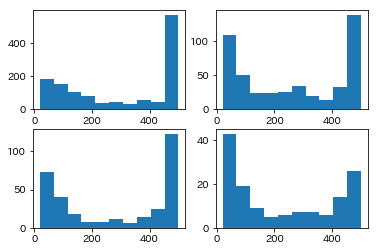

In [10]:
best_scores = dict()
for meter in [0,1,2,3]:
    best_scores[meter] = 0
    meter_size = X_valid.query('meter=={}'.format(meter)).groupby('building_id').size()
    meter_size = meter_size[meter_size!=0]
    for buildingID, cnt in meter_size.items():
        best_scores[meter] += cnt * (min(models[meter].evals_result_[buildingID]['rmse']) ** 2)
    best_scores[meter] = np.sqrt(best_scores[meter] / meter_size.sum())
    

# rmseの計算
meter_counts = X_valid['meter'].value_counts()
mse_score = 0
for i in [0,1,2,3]:
    mse_score += meter_counts[i] * (best_scores[i] ** 2)
print('total rmse = {}'.format(np.sqrt(mse_score / meter_counts.sum())))
print(best_scores)
for meter in [0,1,2,3]:
    print('meter{} best_valid_iteration={}'.format(meter,np.argmin(np.array(models[meter].evals_result_['valid']['rmse']))+1))
    print('meter{} best_valid_score={}'.format(meter,np.min(np.array(models[meter].evals_result_['valid']['rmse'])+1)))
    plt.subplot(2,2,meter+1)
    plt.hist(best_iteration[meter].values())
plt.show()

In [11]:
del_list = [list(), list(), list(), list()]
for meter in [0,1,2,3]:
    for buildingID, itr in best_iteration[meter].items():
        if itr<=20:
            del_list[meter].append(buildingID)
        if itr<=100:
            best_iteration[meter][buildingID] = 100
#         if itr>=int(models[0].n_estimators * 0.98):
#             best_iteration[meter][buildingID] = models[0].n_estimators
            
new_train_fe = train_fe.copy()
new_train_fe['meter_reading'] = target_fe
for meter in [0,1,2,3]:
    new_train_fe = new_train_fe.query('~(meter=={} & building_id == {} & timestamp<20160601)'.format(meter, del_list[meter]))

new_target = new_train_fe['meter_reading']
new_train_fe = new_train_fe.drop('meter_reading', axis=1)

In [12]:
for meter in [0,1,2,3]:
    for i in range(1448):
        if i not in best_iteration[meter]:
            best_iteration[meter][i] = 200

In [13]:
# meter type毎に訓練(全てのデータを使う)
models_all = dict()
for i in [3, 2, 1, 0]:
    print('meter {} start at {}'.format(i,time.ctime()))
    models_all[i] = meter_fit_all(i, new_train_fe.drop('timestamp', axis=1), new_target, random_state=args.seed, n_estimators=args.n_estimators, **lgb_params)
#     models_all[i] = meter_fit_all(i, train_fe.drop('timestamp', axis=1), target_fe, random_state=args.seed, n_estimators=args.n_estimators, **lgb_params)

meter 3 start at Sun Jan 12 12:21:28 2020
500
meter3 done
meter 2 start at Sun Jan 12 12:21:49 2020
500
meter2 done
meter 1 start at Sun Jan 12 12:22:35 2020
500
meter1 done
meter 0 start at Sun Jan 12 12:23:47 2020
500
meter0 done


In [14]:
#save model

save_name = '../model/model_all_use_{}_seed{}_lr{}.pkl'.format(args.train_file.replace('.ftr', ''), args.seed, str(args.learning_rate).replace('.', ''))
with open(save_name, 'wb') as f:
    pickle.dump(models_all, f)

In [15]:
# with open('../model/model_all_5_95_hokan_cleaning_50000tree_seed{}.pkl'.format(args.seed), 'wb') as f:
#     pickle.dump(models_all, f)


# meter type毎のtestの予測    
preds = list()
for i in tqdm([3,2,1,0]):
    preds.append(meter_predict(i, models_all[i], X_test, best_iteration, iteration_mul=args.iteration_mul))

y_preds = pd.concat(preds).sort_index()

 50%|█████     | 162/324 [00:11<00:11, 14.36it/s]


 31%|███       | 153/498 [00:11<00:22, 15.30it/s]


 94%|█████████▍| 469/498 [00:34<00:02, 14.09it/s]


 20%|█▉        | 281/1413 [00:19<01:37, 11.67it/s]


 42%|████▏     | 592/1413 [00:42<01:06, 12.26it/s]


 65%|██████▍   | 916/1413 [01:04<00:38, 12.92it/s]


 86%|████████▌ | 1212/1413 [01:28<00:17, 11.54it/s]


100%|██████████| 4/4 [03:07<00:00, 46.81s/it]


In [16]:
# lgb.plot_importance(models_all[0], importance_type='gain', figsize=(10,20))
# lgb.plot_importance(models_all[0], importance_type='split', figsize=(10,20))

In [17]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['meter_reading'] = (np.expm1(y_preds))
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0

In [ ]:
save_name = '../output/use_{}_seed{}_mul{}_lr{}.csv'.format(args.train_file.replace('.ftr', ''), args.seed, str(args.iteration_mul).replace('.', ''), str(args.learning_rate).replace('.', ''))
submission.to_csv(save_name, index=False)

In [ ]:
submission